In [599]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import log_loss
from collections import Counter

In [651]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = None # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evalaute(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['eta'] = test_samples['eta'].values
        self.testDataNorm['mu'] = test_samples['mu'].values
        self.testDataNorm['model'] = test_samples['model'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def predict(self, proj_samples, proj_ts, showPlot=False): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        # project new data into calibrated space
        #predicted_proba = list()
        abc = RadiusNeighborsClassifier(radius=self.epsilon, outlier_label='most_frequent')
        abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
        y_pred = abc.predict_proba(self.projDataNorm.iloc[:,:22])

        if showPlot:
            fig = plt.figure(figsize=(8,5))
            plt.ylabel('P(M|D)', fontsize=15)
            plt.xlabel('Model', fontsize=15)
            models = abc.classes_
            plt.title(f"True = {proj_samples['model'].values[0]}, Predicted = {abc.predict(self.projDataNorm.iloc[:,:22])[0]}, $\epsilon = {self.epsilon}$", fontsize=15)
            sns.barplot(x=models, y=y_pred[0])
            plt.show()
        
        return [y_pred, abc.predict(self.projDataNorm.iloc[:,:22]), abc.classes_]


    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated

    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon

In [4]:
class featureSpaceOptim:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.projDataNorm = None # normalized projected data
        self.projDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.mmcfit = None # fitted mmc model
        self.optimCalDataNorm = None # optimized calibrated space
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values

        le = LabelEncoder().fit(self.calDataNorm['model'])
        y = le.transform(self.calDataNorm['model'])
        mmc = MMC_Supervised(random_state=666)
        mmc_fit = mmc.fit(self.calDataNorm.iloc[:,:22], y)
        X_mmc = mmc_fit.transform(self.calDataNorm.iloc[:,:22])
        self.mmcfit = mmc_fit
        optimCalDataNorm = pd.DataFrame(X_mmc)
        optimCalDataNorm['N'] = self.calDataNorm['N'].values
        optimCalDataNorm['eta'] = self.calDataNorm['eta'].values
        optimCalDataNorm['mu'] = self.calDataNorm['mu'].values
        optimCalDataNorm['model'] = self.calDataNorm['model'].values
        self.calDataNorm = optimCalDataNorm
        self.learnedMetric = mmc_fit.get_metric()
        
    def project(self, proj_samples, proj_ts): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values

    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        pca = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
        pca_calibrated = pca.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Optimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated
    



### Constrain SINDy

In [19]:
class CustomLibrary(ps.CustomLibrary):
    def __init__(self):
        functions = [lambda x: x, lambda x: x**2, lambda x: x**3]
        function_names = ['x', 'x^2', 'x^3']
        super().__init__(functions, function_names)

t = np.linspace(0,10, 100)
x = np.sin(2*np.pi*t)

# apply SINDy with custom library
custom_library = CustomLibrary()
model = ps.SINDy()
model.fit(x, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0'],
      optimizer=STLSQ())

In [38]:
# Define the logistic map function
def logistic_map(x, r):
    return r * x * (1 - x)

# Generate time-series data using the logistic map
r = 3.7
x0 = 0.5
n_iterations = 1000
x = [x0]
for _ in range(n_iterations - 1):
    x.append(logistic_map(x[-1], r))

x = np.array(x)

# Define a custom library with the terms x and x*(1-x)
class CustomLibrary(ps.CustomLibrary):
    def __init__(self):
        functions = [lambda x: x, lambda x: x * (1 - x)]
        function_names = ['x', 'x(1-x)']
        super().__init__(functions, function_names)

# Apply SINDy with the custom library
custom_library = CustomLibrary()
model = ps.SINDy(feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(x)

# Print the SINDy model

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<__main__.CustomLibrary object at 0x7f7ed84dbeb0>,
      feature_names=['x0'], optimizer=STLSQ(threshold=0.01))

In [219]:
N = 2000
mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95]
eps = 0.0 # normally distributed stochastic forcing 
x = [np.zeros((N, 2)) for i in range(len(mus))] # first column is x, second column is control parameter
for i, mu in enumerate(mus):
    x[i][0] = [np.random.uniform(low=0, high=0.5), mu] # set initial condition to random value between 0 and 0.5
    for k in range(1, N):
        x[i][k, 0] = np.maximum(
            np.minimum(
                mu * x[i][k - 1, 0] * (1 - x[i][k - 1, 0])
                + eps * np.random.randn(),
                1.0,
            ),
            0.0,
        ) # clip generated data to expected bounds [0, 1]
        x[i][k, 1] = mu
x_train = x

In [220]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(x_train, multiple_trajectories=True)
model.print()

(x0)[k+1] = 1.000 x0[k] x1[k] + -1.000 x0[k]^2 x1[k]
(x1)[k+1] = 1.000 x1[k]


ricker's population model

In [552]:
N = 2000
mus = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
eps = 0.02 # normally distributed stochastic forcing 
x = [np.zeros((N, 2)) for i in range(len(mus))] # first column is x, second column is control parameter
for i, mu in enumerate(mus):
    x[i][0] = [np.random.uniform(low=0, high=0.5), mu] # set initial condition to random value between 0 and 0.5
    for k in range(1, N):
        x[i][k, 0] = mu * x[i][k-1, 0] * np.exp(-x[i][k-1, 0]) + eps * np.random.randn()
        x[i][k, 1] = mu
x_train = x

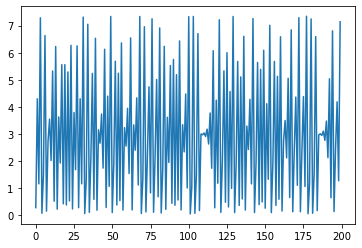

In [525]:
plt.plot(x_train[9][:,0])

In [553]:
from pysindy.feature_library import CustomLibrary, PolynomialLibrary

In [560]:
funcs = [lambda x: np.exp(x), lambda x: x, lambda x: np.exp(-x), lambda x, y: x*y, lambda x: np.exp(-x)]
lib = CustomLibrary(funcs)

In [561]:
library = ps.PolynomialLibrary(degree=5)
optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=lib, 
    discrete_time=True
)
model.fit(x_train, multiple_trajectories=True)
model.print()

(x0)[k+1] = 0.101 f1(x1[k]) + 2.452 f2(x0[k]) + -7.238 f2(x1[k]) + 2.452 f4(x0[k]) + -7.238 f4(x1[k])
(x1)[k+1] = 1.000 f1(x1[k])


/Users/joshua/opt/anaconda3/envs/pysindy/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.04258e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/joshua/opt/anaconda3/envs/pysindy/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.04258e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


# Henon Map

In [598]:
N = 2000
transients = 0
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
eps = 0.07 # normally distributed stochastic forcing 
b = 0.3
x = [np.zeros((N+transients, 3)) for i in range(len(mus))] # first column is x, second column is control parameter
for i, mu in enumerate(mus):
    x[i][0] = [np.random.uniform(low=0, high=0.1), np.random.uniform(low=0, high=0.5), mu] # set initial condition to random value between 0 and 0.5
    for k in range(1, N+transients):
        x[i][k, 0] = 1 - mu * x[i][k-1, 0]**2 + x[i][k-1, 1] + np.random.normal() * eps
        x[i][k, 1] = b*x[i][k-1, 0] + np.random.normal() * eps
        x[i][k, 2] = mu
x_train = x

In [599]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(x_train, multiple_trajectories=True)
model.print()

(x0)[k+1] = 0.999 1 + 0.999 x1[k] + -1.000 x0[k]^2 x2[k]
(x1)[k+1] = 0.299 x0[k]
(x2)[k+1] = 1.000 x2[k]


## Burgers Map

In [771]:
N = 2000
transients = 500 # clip 500 samples from the beginning of each trajectory
mus = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
eps = 0.01 # normally distributed stochastic forcing 
a = 0.75
x = [np.zeros((N+transients, 3)) for i in range(len(mus))] # first column is x, second column is control parameter
for i, mu in enumerate(mus):
    x[i][0] = [np.random.uniform(low=-0.1, high=0.1), np.random.uniform(low=-0.1, high=0.1), mu] # set initial condition to random value between 0 and 0.5
    for k in range(1, N+transients):
        x[i][k, 0] = a * x[i][k-1, 0] - x[i][k-1, 1]**2 + np.random.normal() * eps
        x[i][k, 1] = mu * x[i][k-1, 1] + x[i][k-1, 0] * x[i][k-1, 1] + np.random.normal() * eps
        x[i][k, 2] = mu
x_train = [x[i][transients:] for i in range(len(mus))]

In [772]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(x_train, multiple_trajectories=True)
model.print()

(x0)[k+1] = 0.750 x0[k] + -1.001 x1[k]^2
(x1)[k+1] = 1.001 x0[k] x1[k] + 1.000 x1[k] x2[k]
(x2)[k+1] = 1.000 x2[k]


## Holme's Cubic Map

In [1438]:
N = 500
transients = 500 # clip 500 samples from the beginning of each trajectory
mus = [0.18, 0.19, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26]
eps = np.random.uniform(low=0., high=0.001) # normally distributed stochastic forcing 
d = 2.77
x = [np.zeros((N+transients, 3)) for i in range(len(mus))] # first column is x, second column is control parameter
for i, mu in enumerate(mus):
    x[i][0] = [np.random.uniform(low=-0.01, high=0.01), np.random.uniform(low=-0.01, high=0.01), mu] # set initial condition to random value between 0 and 0.5
    for k in range(1, N+transients):
        x[i][k, 0] = x[i][k-1, 1] + np.random.normal() * eps
        x[i][k, 1] = -mu * x[i][k-1, 0] + d * x[i][k-1, 1] - x[i][k-1, 1]**3 + np.random.normal() * eps
        x[i][k, 2] = mu
x_train = [x[i][transients:] for i in range(len(mus))]

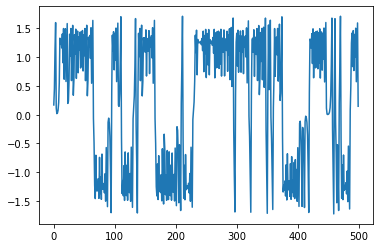

In [1439]:
plt.plot(x_train[1][:,0])

In [1431]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(x_train, multiple_trajectories=True)
model.print()

(x0)[k+1] = 1.000 x1[k]
(x1)[k+1] = 2.770 x1[k] + -1.000 x0[k] x2[k] + -1.000 x1[k]^3
(x2)[k+1] = 1.000 x2[k]


## Log Map Identification

Calibrate space with log map, cubic map, henon map and burgers map

In [7]:
class LogMap:
    def __init__(self):
        self.mu = None
        self.model = 'LogMap'
        self.transients = 500
        # store sampling range
        self.mu_min = 2.5
        self.mu_max = 3.95
    
    def set_mu(self, mu):
        self.mu = mu
        
    # generate data such that it is also compatible with SINDy
    def generate(self, N, eta):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = np.maximum(np.minimum(self.mu * x[i-1, 0] * (1 - x[i - 1, 0]) + eta * np.random.randn(), 1), 0)
            x[i, 1] = self.mu
        return x[self.transients:]


In [8]:
class HenonMap:
    def __init__(self):
        self.mu = None
        self.model = 'HenonMap'
        self.transients = 500
        self.b = 0.3
        # store sampling range
        self.mu_min = 0.1
        self.mu_max = 1.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate(self, N, eta):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1] + eta * np.random.randn()
            x[i, 1] = self.b * x[i-1, 0] + eta * np.random.randn()
            x[i, 2] = self.mu
        return x[self.transients:]

In [9]:
class BurgersMap:
    def __init__(self):
        self.mu = None
        self.model = 'BurgersMap'
        self.transients = 500
        self.a = 0.75
        # store sampling range
        self.mu_min = 0.9
        self.mu_max = 1.8

    def set_mu(self, mu):
        self.mu = mu
    
    # generate data such that it is also compatible with SINDy
    def generate(self, N, eta):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 + eta * np.random.randn()
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1] + eta * np.random.randn()
            x[i, 2] = self.mu
        return x[self.transients:]
    

In [10]:
class CubicMap:
    def __init__(self):
        self.mu = None
        self.model = 'CubicMap'
        self.transients = 500
        self.d = 2.77
        # store sampling range
        self.mu_min = 0.18
        self.mu_max = 0.26
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate(self, N, eta):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 1] + eta * np.random.randn()
                x[i, 1] =  -self.mu * x[i-1, 0] + self.d * x[i-1, 1] - x[i-1, 1]**3 + eta * np.random.randn()
                x[i, 2] =  self.mu
            return x[self.transients:]
    

In [11]:
class TinkerBellMap:
    # https://www.mdpi.com/2076-3417/8/12/2640
    def __init__(self):
        self.mu = None
        self.model = 'TinkerBellMap'
        self.transients = 500
        self.mu_min = 0.1 # here mu (critical param is arbitrarily set to c as per Sprott's definition)
        self.mu_max = 1.6
        self.a = 0.9
        self.b = -0.6013
        self.d = 0.5 
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate(self, N, eta):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta * np.random.randn()
                x[i, 2] =  self.mu
            return x[self.transients:]
    

In [10]:
N = 2000
mus = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
eps = 0.01
sols_list = list()
for mu in mus:
    x = TinkerBellMap()
    x.set_mu(mu)
    sol = x.generate(N, eps)
    sols_list.append(sol)

In [11]:
optimizer = ps.STLSQ(threshold=0.3)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True,
    feature_names=['x', 'y', 'mu'],
)
model.fit(sols_list, multiple_trajectories=True)
model.print()

(x)[k+1] = 0.900 x[k] + -0.601 y[k] + 1.001 x[k]^2 + -1.000 y[k]^2
(y)[k+1] = 0.500 y[k] + 1.999 x[k] y[k] + 1.000 x[k] mu[k]
(mu)[k+1] = 1.000 mu[k]


In [54]:
N = 100
mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95]
eps = 0.001
sols_list = list()
for mu in mus:
    x = LogMap()
    x.set_mu(mu)
    sol = x.generate(N, eps)
    sols_list.append(sol)

In [55]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(sols_list, multiple_trajectories=True)
model.print()

(x0)[k+1] = 1.000 x0[k] x1[k] + -1.000 x0[k]^2 x1[k]
(x1)[k+1] = 1.000 x1[k]


In [1862]:
N = 100
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
eps = 0.001
sols_list = list()
for mu in mus:
    x = HenonMap()
    x.set_mu(mu)
    sol = x.generate(N, eps)
    sols_list.append(sol)


In [1863]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(sols_list, multiple_trajectories=True)
model.print()

(x0)[k+1] = 1.000 1 + 1.001 x1[k] + -1.000 x0[k]^2 x2[k]
(x1)[k+1] = 0.300 x0[k]
(x2)[k+1] = 1.000 x2[k]


In [2133]:
N = 2000
mus = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.65, 1.7, 1.8]
eps = 0.01
sols_list = list()
for mu in mus:
    x = BurgersMap()
    x.set_mu(mu)
    sol = x.generate(N, eps)
    sols_list.append(sol)

In [2134]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(sols_list, multiple_trajectories=True)
model.print()

(x0)[k+1] = 0.750 x0[k] + -1.000 x1[k]^2
(x1)[k+1] = 1.001 x0[k] x1[k] + 1.000 x1[k] x2[k]
(x2)[k+1] = 1.000 x2[k]


In [1873]:
N = 2000
mus = [0.18, 0.19, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26]
eps = 0.001
sols_list = list()
for mu in mus:
    x = CubicMap()
    x.set_mu(mu)
    sol = x.generate(N, eps)
    sols_list.append(sol)

In [1874]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True
)
model.fit(sols_list, multiple_trajectories=True)
model.print()

(x0)[k+1] = 1.000 x1[k]
(x1)[k+1] = 2.770 x1[k] + -1.000 x0[k] x2[k] + -1.000 x1[k]^3
(x2)[k+1] = 1.000 x2[k]


## Calibrate Instance Space

In [746]:
def sample_maps(num_samples, N_val=None, eta_val=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    models = [LogMap(), HenonMap(), BurgersMap(), TinkerBellMap()]
    sel_model = list()
    lengths = list()
    mus = list()
    etas = list()
    sols = list()
    for i in range(num_samples):
        model = np.random.choice(models) # pick a model
        sel_model.append(model)
        mu = np.random.uniform(low=model.mu_min, high=model.mu_max) # pick a mu
        mus.append(mu)
        if N_val is None:
            N = np.random.randint(low=50, high=5000)
        else:
            N = N_val
        lengths.append(N)
        if eta_val is None:
            eta = np.random.uniform(low=0., high=.1) # pick a noise level
        else:
            eta = eta_val
        etas.append(eta)
        model.set_mu(mu)
        sol = model.generate(N, eta)
        sols.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols[i][:,0])['values'] for i in range(len(sols))])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['mu'] = mus
    df['eta'] = etas
    df['model'] = [sel_model[i].model for i in range(len(sel_model))]
    ts = sols
    return df, ts


In [13]:
df, ts = sample_maps(10000, seed=235)

In [145]:
def generate_LogMap(N_val, eta_val, seed=None):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95] # mu windows to sample from - taken from SINDy paper
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = LogMap()
        x.set_mu(mu)
        sol = x.generate(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['LogMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

### Discard NaNs
Trying to find a good way around this, but for now, given that the proportion of instances where the discrete map trajectory blows up is very small, we should be able to discard them without having a significant impact on the estimation of the posterior. Interestingly, it always the burger's map that blows up.

In [14]:
nan_count = df.isna().any(axis=1).sum() # check for nan values
print('Number of nan values: ', nan_count)
print('Percentage of samples with nan values: ',(nan_count/len(df))*100)
nan_indices = df.isna().any(axis=1).to_numpy().nonzero()[0]
print(f"{df.iloc[nan_indices]['model'].value_counts()}")

Number of nan values:  0
Percentage of samples with nan values:  0.0
Series([], Name: model, dtype: int64)


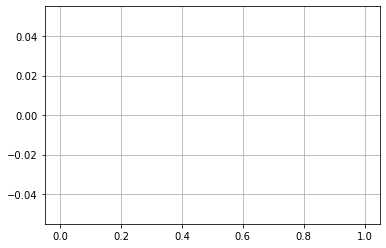

In [15]:
df.iloc[nan_indices]['mu'].hist()

In [168]:
nan_indices = df.isna().any(axis=1).to_numpy().nonzero()[0] # get NaN indices to remove corresponding TS
df = df.dropna() # drop NaN rows
ts = [ts[i] for i in range(len(ts)) if i not in nan_indices] # drop NaN TS

In [652]:
space = featureSpace()

In [653]:
space.fit(df, ts)

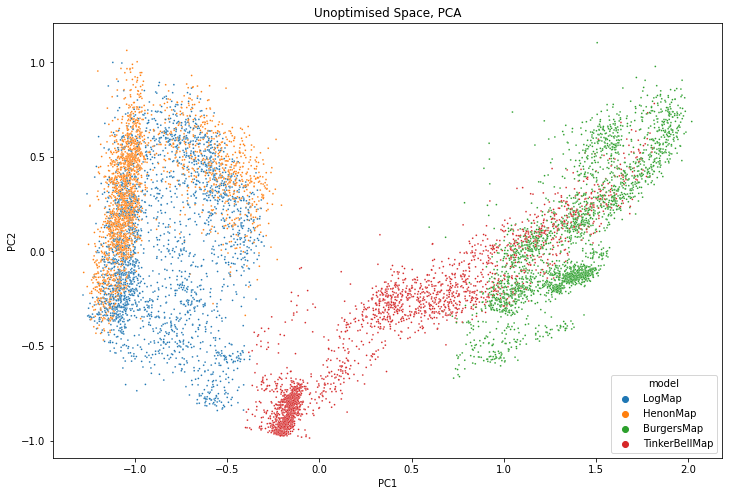

In [561]:
embed = space.pcaViz(return_df=True)

### Generate Evaluation Data for Setting of Epsilon

In [19]:
def evaluate_space(model, num_iter, showPlot=True):
    meta_acc = list()
    meta_logloss = list()
    radii = np.linspace(0.1, 2, 20)
    for i in range(num_iter):
        print(f'iteration: {i}')
        # generate calibration data 
        df_cal, ts_cal = sample_maps(5000)
        df_cal = df_cal.dropna()
        print(len(df_cal))
        # generate test data
        df_test, ts_test = sample_maps(1000) 
        df_test = df_test.dropna()
        print(len(df_test))
        # train the space
        model.fit(df_cal, ts_cal)
        df_eval, predicted_proba = space.evalaute(df_test, ts_test, radii)
        meta_acc.append(df_eval['accuracy'].values)
        meta_logloss.append(df_eval['logloss'].values)
    
    optimal_epsilon_ll = radii[np.argmin(np.mean(meta_logloss, axis=0))]
    print(f'Optimal Epsilon (LogLoss): {optimal_epsilon_ll}')
    optimal_epsilon_acc = radii[np.argmax(np.mean(meta_acc, axis=0))]
    print(f'Optimal Epsilon (Accuracy): {optimal_epsilon_acc}')
    
    if showPlot:
        fig, ax = plt.subplots(1,2, figsize=(22,8))
        ax[0].errorbar(radii, np.mean(meta_acc, axis=0), yerr=np.std(meta_acc, axis=0), label='std', capsize=3)
        ax[0].axvline(x=radii[np.argmax(np.mean(meta_acc, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[0].set_xlabel('$\epsilon$')
        ax[0].set_ylabel('Accuracy')

        ax[1].errorbar(radii, np.mean(meta_logloss, axis=0), yerr=np.std(meta_logloss, axis=0), label='std', capsize=3)
        ax[1].axvline(x=radii[np.argmin(np.mean(meta_logloss, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[1].set_xlabel('$\epsilon$')
        ax[1].set_ylabel('Log Loss')
        plt.show()
    

iteration: 0
5000
1000
iteration: 1


/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:21: RuntimeWarning: overflow encountered in double_scalars
  x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:21: RuntimeWarning: invalid value encountered in double_scalars
  x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:22: RuntimeWarning: overflow encountered in double_scalars
  x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta * np.random.randn()


4999
1000
iteration: 2


/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:21: RuntimeWarning: overflow encountered in double_scalars
  x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:21: RuntimeWarning: invalid value encountered in double_scalars
  x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:22: RuntimeWarning: overflow encountered in double_scalars
  x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta * np.random.randn()


4999
1000
iteration: 3
5000
1000
iteration: 4
5000
1000
Optimal Epsilon (LogLoss): 0.9999999999999999
Optimal Epsilon (Accuracy): 0.6


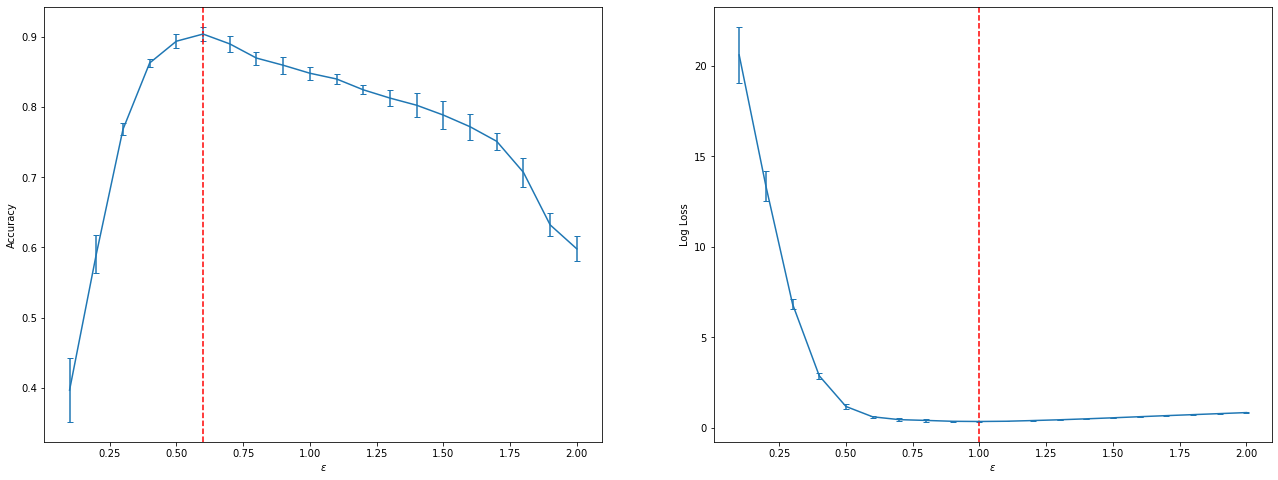

In [20]:
evaluate_space(space, 5)

In [654]:
space.fit(df, ts)
space.setEpsilon(1.0)

In [175]:
test_df, test_ts = sample_maps(1)

[[0.84046693 0.         0.         0.15953307]]


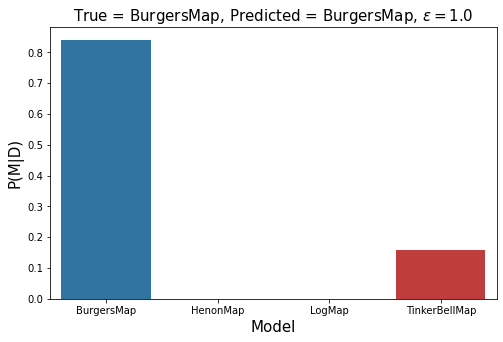

In [176]:
space.predict(test_df, test_ts, True)

In [199]:
test_df, test_ts = generate_LogMap(5000, 0.01)

Constrain SINDy to candidate models with polynomials of up to order 5. Include interaction terms i.e., xy, x^2y, x^2y^2, etc.

In [213]:
optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True,
    feature_names=['x', 'mu']
)

Set tolerance on recovered coefficients to be 1e-1. Require that the recovered coefficients are within 10% of the true coefficients.

In [231]:
library.get_feature_names()

['1',
 'x0',
 'x1',
 'x0^2',
 'x0 x1',
 'x1^2',
 'x0^3',
 'x0^2 x1',
 'x0 x1^2',
 'x1^3',
 'x0^4',
 'x0^3 x1',
 'x0^2 x1^2',
 'x0 x1^3',
 'x1^4',
 'x0^5',
 'x0^4 x1',
 'x0^3 x1^2',
 'x0^2 x1^3',
 'x0 x1^4',
 'x1^5']

For the log map, we need to implement checks to ensure that only the correct coefficients 'light up' in the recovered model. Then, we implement a check to ensure that the recovered coefficients are within 10% of the true coefficients:
- Check for only two non-zero entries corresponding to the (x0x1) and (x1x0^2) terms where x0 is x and x1 is mu.
- Check the values of the coefficients are within 10% of the true coefficients i.e. 1 for x0x1 and -1 for x1x0^2.
- Can later add in possibility of other terms being non-zero, but still within 10% of 0 -> these terms are likely to be negated if we fine-tune the sparsity parmaeter.

In [242]:
model.fit(test_ts, multiple_trajectories=True)
model.print()

(x)[k+1] = 1.000 x[k] mu[k] + -1.000 x[k]^2 mu[k]
(mu)[k+1] = 1.000 mu[k]


In [243]:
coeffs = model.coefficients()
x_coeffs = coeffs[0]
mu_coeffs = coeffs[1]
print(x_coeffs)

[ 0.          0.          0.          0.          0.99988914  0.
  0.         -0.99985812  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


In [250]:
if np.count_nonzero(x_coeffs) > 0:
    print(f'Non-Zero Entries X: {[library.get_feature_names()[i] for i in np.nonzero(x_coeffs)[0]]}')
    print(f'Values of Non-Zero Entries X: {x_coeffs[np.nonzero(x_coeffs)]}')
    print(f'Non-Zero Entries Mu: {[library.get_feature_names()[i] for i in np.nonzero(mu_coeffs)[0]]}')
    print(f'Values of Non-Zero Entries Mu: {mu_coeffs[np.nonzero(mu_coeffs)]}')

Non-Zero Entries X: ['x0 x1', 'x0^2 x1']
Values of Non-Zero Entries X: [ 0.99988914 -0.99985812]
Non-Zero Entries Mu: ['x1']
Values of Non-Zero Entries Mu: [1.]


V1 - Strict Criteria:
- Only two non-zero terms allowed
- Values must be within 10% of the true coefficients

In [443]:
def is_within_bounds(value, ground_truth, tolerance):
    lower_bound = ground_truth - (tolerance * np.abs(ground_truth))
    upper_bound = ground_truth + (tolerance * np.abs(ground_truth))
    return lower_bound <= value <= upper_bound

def isLogMap(sindyModel, test_ts, tolerance=0.1, showEq = False):
    sindyModel.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        sindyModel.print()
    coeffs = sindyModel.coefficients()
    x_coeffs, mu_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(mu_coeffs)[0]

    ground_truth_coeffs = {4: 1.0, 7: -1.0, 2: 1.0}
    expected_non_zero_idx_x = {4, 7}
    expected_non_zero_idx_mu = {2}

    if set(non_zero_idx_x) == expected_non_zero_idx_x and set(non_zero_idx_mu) == expected_non_zero_idx_mu:
        for idx, ground_truth_coeff in ground_truth_coeffs.items():
            if idx in non_zero_idx_x:
                if not is_within_bounds(x_coeffs[idx], ground_truth_coeff, tolerance):
                    return False
            elif idx in non_zero_idx_mu:
                if not is_within_bounds(mu_coeffs[idx], ground_truth_coeff, tolerance):
                    return False
        return True

    return False

Use soft voting to determine the predicted class across ten samples. Could potentially use weights in V2 where we prioritise more confident predictions according to some specified threshold probability i.e. p(Model|D) > 0.5.

In [713]:
# similar purpose as the SINDy isLogMap function, but for instance space
def isLogMap_isa(space, check_df, check_ts):
    # assume space is already calibrated/fit
    probs, preds, classes = space.predict(check_df, check_ts)
    avg_probs = np.mean(probs, axis=0) # soft voting scheme
    avg_index = np.argmax(avg_probs) 
    predicted_class = classes[avg_index]
    if predicted_class == 'LogMap':
        return True
    else:
        return False

In [786]:
test_df, test_ts = generate_LogMap(1000, 0.01)

In [789]:
np.mean(space.predict(test_df, test_ts)[0], axis=0)

array([0.        , 0.27853929, 0.6409617 , 0.08049901])

Fix eta to 0.01 and vary N, evaluate SINDy test

In [733]:
num_iter = 1000

# setup SINDy
optimizer = ps.STLSQ(threshold=0.1) 
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True,
    feature_names=['x', 'mu'],
)

# setup instance space
space = featureSpace()
space.fit(df, ts) # fit space with training data 
space.setEpsilon(1.0)

Ns = np.linspace(20, 1000, 50, dtype=int)
correct_per_N_SINDY = list() # per N
correct_per_N_isa = list()
for N in Ns:
    results_SINDY = list()
    results_ISA = list()
    for it in range(num_iter):
        check_df, check_ts = generate_LogMap(N, eta_val=0.01)
        results_SINDY.append(isLogMap(model, check_ts))
        results_ISA.append(isLogMap_isa(space, check_df, check_ts))
    correct_identifications_SINDY = np.count_nonzero(results_SINDY)
    correct_identifications_ISA = np.count_nonzero(results_ISA)
    correct_per_N_SINDY.append(correct_identifications_SINDY)
    correct_per_N_isa.append(correct_identifications_ISA)

In [734]:
percentage_identified_SINDY = np.array(correct_per_N_SINDY) / num_iter
percentage_identified_ISA = np.array(correct_per_N_isa) / num_iter

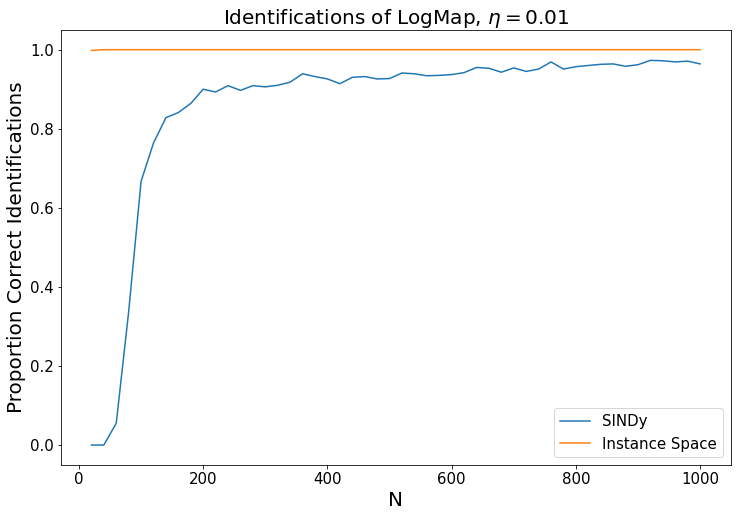

In [791]:
plt.figure(figsize=(12,8))
plt.title('Identifications of LogMap, $\eta = 0.01$', fontsize=20)
plt.plot(Ns, percentage_identified_SINDY, label='SINDy')
plt.plot(Ns, percentage_identified_ISA, label='Instance Space')
plt.legend(fontsize=15)
plt.xlabel('N', fontsize=20)
plt.ylabel('Proportion Correct Identifications', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [798]:
check_df, check_ts = generate_LogMap(N, eta_val=0.01)

Our method outperforms SINDy for all N

In [738]:
num_iter = 1000

# setup SINDy
optimizer = ps.STLSQ(threshold=0.1) 
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    discrete_time=True,
    feature_names=['x', 'mu'],
)

# setup instance space
space = featureSpace()
space.fit(df, ts) # fit space with training data 
space.setEpsilon(1.0)

Ns = np.linspace(20, 1000, 50, dtype=int)
correct_per_N_SINDY = list() # per N
correct_per_N_isa = list()
for N in Ns:
    results_SINDY = list()
    results_ISA = list()
    for it in range(num_iter):
        check_df, check_ts = generate_LogMap(N, eta_val=0.1)
        results_SINDY.append(isLogMap(model, check_ts))
        results_ISA.append(isLogMap_isa(space, check_df, check_ts))
    correct_identifications_SINDY = np.count_nonzero(results_SINDY)
    correct_identifications_ISA = np.count_nonzero(results_ISA)
    correct_per_N_SINDY.append(correct_identifications_SINDY)
    correct_per_N_isa.append(correct_identifications_ISA)

In [739]:
percentage_identified_SINDY_highEta = np.array(correct_per_N_SINDY) / num_iter
percentage_identified_ISA_highEta = np.array(correct_per_N_isa) / num_iter

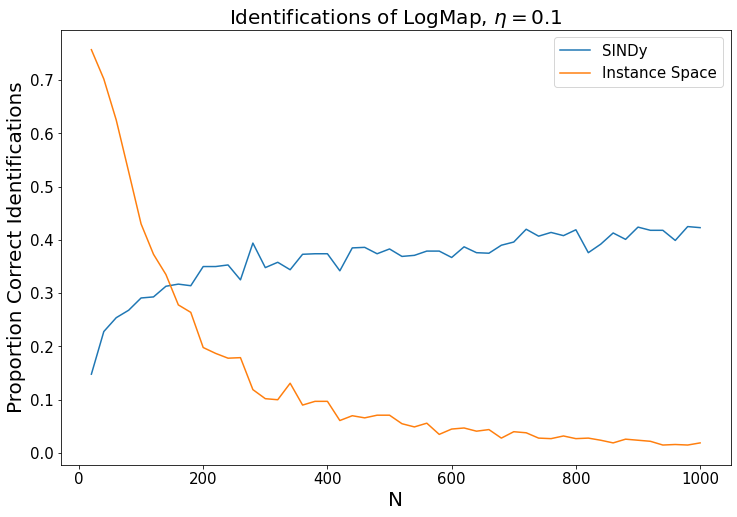

In [745]:
plt.figure(figsize=(12,8))
plt.title('Identifications of LogMap, $\eta = 0.1$', fontsize=20)
plt.plot(Ns, percentage_identified_SINDY_highEta, label='SINDy')
plt.plot(Ns, percentage_identified_ISA_highEta, label='Instance Space')
plt.legend(fontsize=15)
plt.xlabel('N', fontsize=20)
plt.ylabel('Proportion Correct Identifications', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

These results are becuase the instance space was only calibrated in the range eta = [0, 0.01]

In [736]:
isLogMap(model, check_ts, showEq=True)

(x)[k+1] = 1.000 x[k] mu[k] + -1.000 x[k]^2 mu[k]
(mu)[k+1] = 1.000 mu[k]


True

In [756]:
df2, ts2 = sample_maps(30000, seed=69)

/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:21: RuntimeWarning: overflow encountered in double_scalars
  x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:21: RuntimeWarning: invalid value encountered in double_scalars
  x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/3423380714.py:22: RuntimeWarning: overflow encountered in double_scalars
  x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn/T/ipykernel_17871/1636198549.py:19: RuntimeWarning: overflow encountered in double_scalars
  x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 + eta * np.random.randn()
/var/folders/z3/q9sgsjh15j1_0jw8qp3s0xn40000gn

In [757]:
nan_count = df2.isna().any(axis=1).sum() # check for nan values
print('Number of nan values: ', nan_count)
print('Percentage of samples with nan values: ',(nan_count/len(df2))*100)
nan_indices = df2.isna().any(axis=1).to_numpy().nonzero()[0]
print(f"{df2.iloc[nan_indices]['model'].value_counts()}")

Number of nan values:  6376
Percentage of samples with nan values:  21.253333333333334
TinkerBellMap    5259
BurgersMap        986
HenonMap          131
Name: model, dtype: int64


## Optimised Space

In [346]:
space_optimised = featureSpaceOptim()

In [347]:
space_optimised.fit(df, ts)

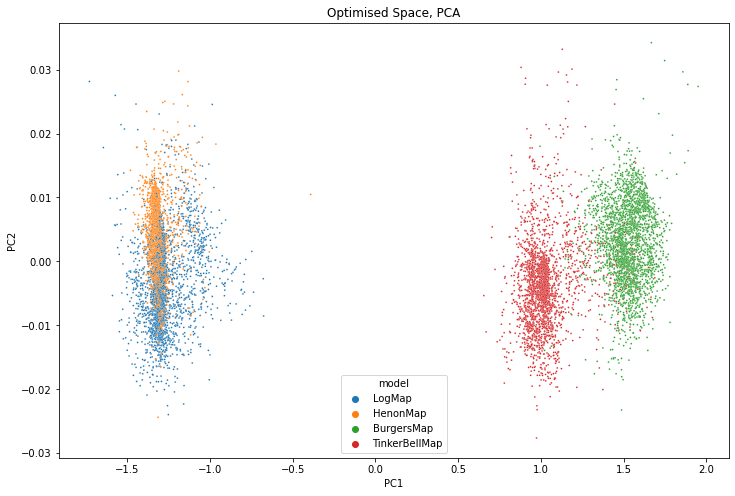

In [348]:
optimised_embed = space_optimised.pcaViz(return_df=True)